### 1. Installing dependencies

In [52]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

### 2. importing packages

In [53]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


from gym_anytrading.envs import StocksEnv
from finta import TA

### Constant

In [54]:
WINDOW_SIZE = 25
AMOUNT_OF_EPISODES = 50
INITIAL_CAPITAL = 1000
DATASET_PATH = '/content/TESLA RL training data - 1 Sentiment 12.2024.csv'


### Methods

In [55]:
def calculate_calmar_ratio(initial_capital,final_capital,peak_value,tough_value):

  cummulative_return = final_capital / initial_capital - 1

  annualized_return = (1 + cummulative_return) ** (365 / 252) - 1

  mdd = (peak_value - tough_value) / peak_value

  calmar_ratio = annualized_return / mdd
  return calmar_ratio

### 3. Read the dataset and preprocess it

In [56]:
df = pd.read_csv(DATASET_PATH)

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)

df.sort_index(inplace=True)

df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

df['Day'] = df.index.dayofweek

### Calculate technical indicators using finta  

In [57]:
df['SMA'] = TA.SMA(df, WINDOW_SIZE)
df['RSI'] = TA.RSI(df, WINDOW_SIZE)
df['MOM'] = TA.MOM(df, WINDOW_SIZE)
df['EMA'] = TA.EMA(df, WINDOW_SIZE)
df['AROONOSC'] = TA.AO(df,WINDOW_SIZE)
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Close,High,Low,Open,Volume,Sentiment,Predicted_Close,Day,SMA,RSI,MOM,EMA,AROONOSC
Date,,,,,,,,,,,,,,
2014-01-02,-1.599626,-1.599626,-1.609751,-1.606774,-1.604716,-0.191212,0,-1.531689,3,0.0,0.000000,0.0,-1.599626,0.0
2014-01-03,-1.608201,-1.608201,-1.614303,-1.573761,-1.601537,-0.530397,0,-1.566396,4,0.0,0.000000,0.0,-1.604085,0.0
2014-01-06,-1.648851,-1.648851,-1.642399,-1.627870,-1.601537,-0.379111,0,-1.551651,0,0.0,0.000000,0.0,-1.620216,0.0
2014-01-07,-1.611377,-1.611377,-1.642399,-1.627709,-1.639363,-0.453380,0,-1.581032,1,0.0,44.400253,0.0,-1.617734,0.0
2014-01-08,-1.580889,-1.580889,-1.590601,-1.571184,-1.619814,-0.196936,0,-1.576943,2,0.0,59.601318,0.0,-1.609141,0.0


### Trading Environment

In [59]:
class MyCustomEnv(StocksEnv):

  def __init__(self, df, window_size, frame_bound, **kwargs):
    super().__init__(df, window_size, frame_bound, **kwargs)

  def reset(self, seed=None, options=None):
    self._truncated = False
    self._current_tick = self._start_tick
    self._last_trade_tick = self._current_tick - 1
    self._position = Positions.Short
    self._position_history = (self.window_size * [None]) + [self._position]
    self._total_reward = INITIAL_CAPITAL
    self._total_profit = INITIAL_CAPITAL  # unit
    self._first_rendering = True
    self.history = {}

    observation = self._get_observation()
    info = self._get_info()

    if self.render_mode == 'human':
        self._render_frame()

    return observation, info

  def _process_data (self):
    start = self.frame_bound[0] - self.window_size
    # print('env',env._position)
    end = self.frame_bound[1]
    prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = self.df.loc[:, ['Close','Sentiment','Predicted_Close','SMA', 'RSI', 'MOM', 'EMA', 'AROONOSC']].to_numpy()[start:end]
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    signal_features = np.concatenate((signal_features, diff_reshaped), axis=1)


    return prices, signal_features





  def _calculate_reward(self, action):
      step_reward = 0

      trade = False
      if (
          (action == Actions.Buy.value and self._position == Positions.Short) or
          (action == Actions.Sell.value and self._position == Positions.Long)
      ):
          trade = True

      if trade:
          current_price = self.prices[self._current_tick]
          last_trade_price = self.prices[self._last_trade_tick]
          price_diff = current_price - last_trade_price

          # if self._position == Positions.Long:
          step_reward += price_diff

      return step_reward

  def _update_profit(self, action):
      trade = False
      if (
          (action == Actions.Buy.value and self._position == Positions.Short) or
          (action == Actions.Sell.value and self._position == Positions.Long)
      ):
          trade = True

      if trade or self._truncated:
          current_price = self.prices[self._current_tick]
          last_trade_price = self.prices[self._last_trade_tick]

          # if self._position == Positions.Long:
          shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
          self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price

  def step(self, action):
    self._truncated = False
    self._current_tick += 1

    if self._current_tick == self._end_tick:
        self._truncated = True

    step_reward = self._calculate_reward(action)
    self._total_reward += step_reward

    self._update_profit(action)

    trade = False
    if (
        (action == Actions.Buy.value and self._position == Positions.Short) or
        (action == Actions.Sell.value and self._position == Positions.Long)
    ):
        trade = True

    if trade:
        self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick

    self._position_history.append(self._position)
    observation = self._get_observation()
    info = self._get_info()
    self._update_history(info)

    if self.render_mode == 'human':
        self._render_frame()

    return observation, step_reward, False, self._truncated, info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dataset split

In [60]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  1258
test_df:  252


In [61]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

In [62]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-1.59962597,  0.        , -1.53168863,  0.        ,  0.        ,
         0.        , -1.59962597,  0.        ,  0.        ]])

In [63]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [64]:
env.action_space.sample()

0

Sell = 0

Buy = 1

In [65]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (25, 9), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [66]:
env.observation_space.sample()

array([[ 4.39804979e+09, -8.02105600e+09,  8.95969587e+09,
         2.09002355e+09, -4.03793562e+09, -3.26078016e+08,
        -3.15604147e+09, -8.59410432e+09, -8.79299072e+09],
       [-1.12338202e+09,  1.83190323e+09,  5.42697523e+09,
        -9.97825536e+09,  9.41182528e+08, -6.14990950e+09,
         7.68144384e+09, -4.40403046e+09, -5.87744000e+08],
       [ 5.30342298e+09,  1.80757888e+09, -7.85360448e+08,
        -5.50167552e+09,  7.25308979e+09,  9.47874714e+09,
         3.38291098e+09, -5.21638042e+09,  2.91891584e+09],
       [ 2.22240845e+09,  2.73526374e+09, -7.93759539e+09,
         3.13529728e+09, -7.09041459e+09, -6.20315648e+09,
        -6.55491021e+09,  7.82383258e+09,  9.93355162e+09],
       [ 4.92631488e+08, -6.35279770e+09, -7.20699136e+08,
        -4.98707200e+09,  2.39401165e+09,  7.26481152e+09,
        -2.53425792e+09, -5.66788710e+09,  1.43578765e+09],
       [ 5.34596045e+09,  3.82944640e+09,  3.32675616e+08,
        -8.03329434e+09, -9.35582515e+09,  1.900605

### 4. Create the environment and do some random action on it

info: {'total_reward': 1002.4520339856487, 'total_profit': -0.11562943594320343, 'position': <Positions.Short: 0>}


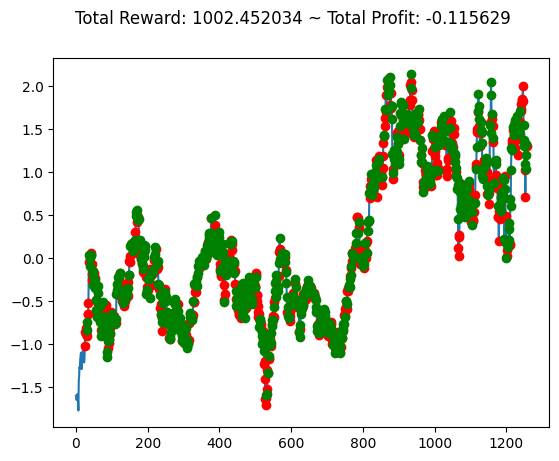

In [67]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

### 5 creating and training the model

In [68]:
model = A2C("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=62900)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 300      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.685   |
|    explained_variance | 0.00114  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0886  |
|    value_loss         | 0.0191   |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 196       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.663    |
|    explained_variance | -4.47e-05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | 0.0706    |
|    value_loss         | 

### Evaluate model

info: {'total_reward': 1002.2184538942729, 'total_profit': 2632.9478955972536, 'position': <Positions.Long: 1>}
peak_value 2632.9478955972536
tough_value -2258.9550169930462
calmar_ratio 1.6492253824467893


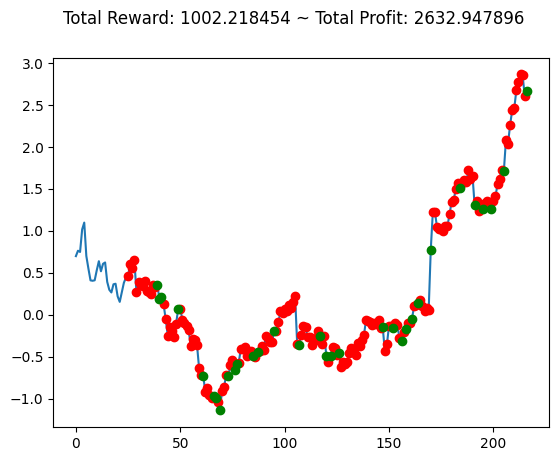

info: {'total_reward': 1002.160813466435, 'total_profit': 2334.04092950108, 'position': <Positions.Short: 0>}
peak_value 2578.4813547720973
tough_value -1886.0006224078115
calmar_ratio 1.3938053848572567


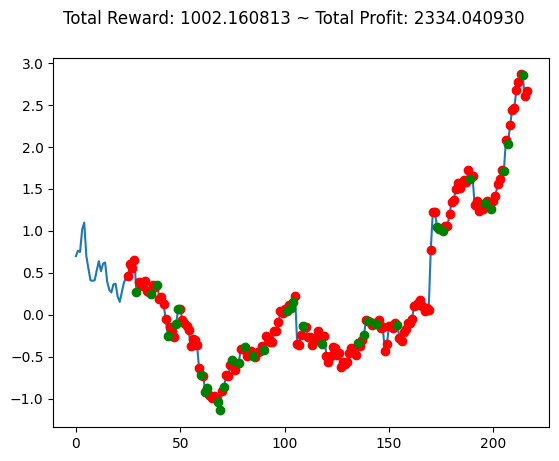

info: {'total_reward': 1002.2184538942727, 'total_profit': 2632.947895597254, 'position': <Positions.Long: 1>}
peak_value 2687.111018940401
tough_value -1095.4781660019212
calmar_ratio 2.1767673161978673


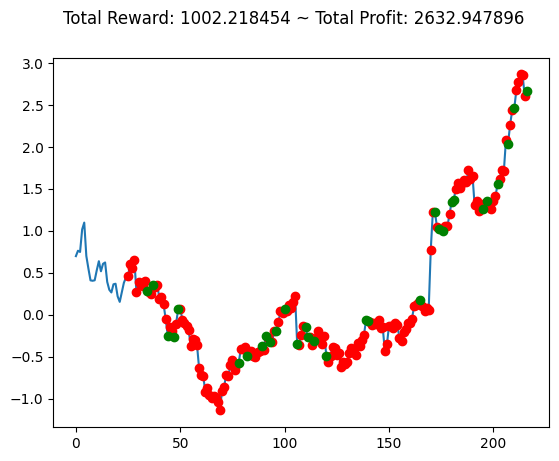

info: {'total_reward': 1002.3283367379872, 'total_profit': 2478.9933750552327, 'position': <Positions.Short: 0>}
peak_value 2620.592364345218
tough_value -1693.9098197266198
calmar_ratio 1.6548668861751945


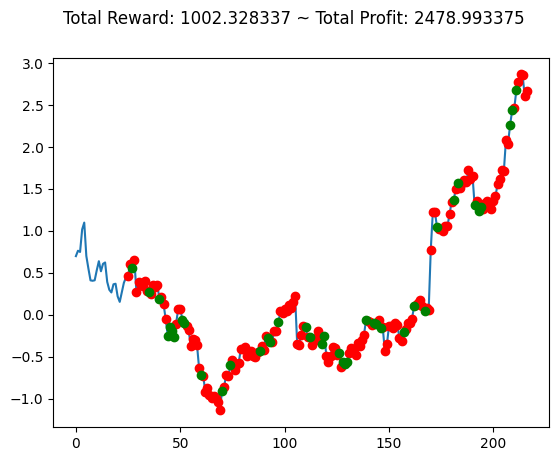

info: {'total_reward': 1002.3283367379872, 'total_profit': 2197.5641869010196, 'position': <Positions.Short: 0>}
peak_value 2323.088067237376
tough_value -1943.0784547273206
calmar_ratio 1.1587986218769784


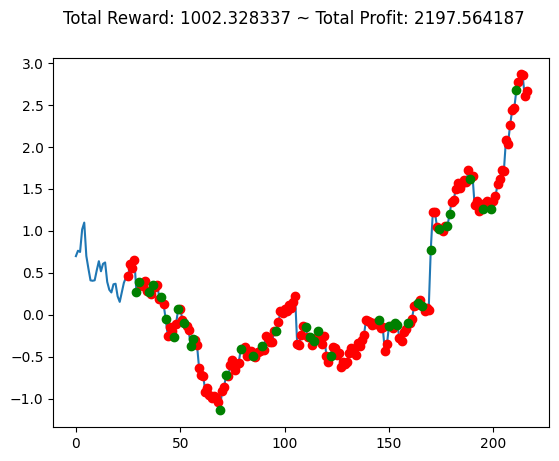

In [69]:
calmar_ratio_list = []
total_reward_list = []
total_profit_list = []

for i in range(5):

  env = MyCustomEnv(df=test_df, frame_bound=(60, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset()
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          peak_value = np.max(env.history['total_profit'])
          tough_value = np.min(env.history['total_profit'])
          final_capital = info['total_profit']
          print('peak_value',peak_value)
          print('tough_value',tough_value)
          calmar_ratio = calculate_calmar_ratio(INITIAL_CAPITAL,final_capital,peak_value,tough_value)
          print('calmar_ratio',calmar_ratio)
          calmar_ratio_list.append(calmar_ratio)
          total_reward_list.append(info['total_reward'])
          total_profit_list.append(info['total_profit'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

In [73]:
calmar_ratio_list

[1.6492253824467893,
 1.3938053848572567,
 2.1767673161978673,
 1.6548668861751945,
 1.1587986218769784]

In [76]:
print('Average Calmar Ratio: ', np.mean(calmar_ratio_list))
print('Average Total Reward: ', np.mean(total_reward_list))
print('Average Total Profit: ', np.mean(total_profit_list))



Average Calmar Ratio:  1.6066927183108173
Average Total Reward:  1002.250878946191
Average Total Profit:  2455.298856530368


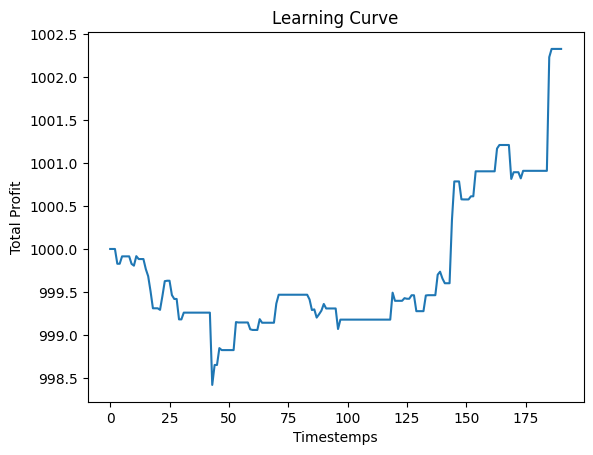

In [72]:
plt.plot(env.history['total_reward'])
plt.xlabel('Timestemps')
plt.ylabel('Total Profit')
plt.title('Learning Curve')
plt.show()